# RBM és DBN hálózatok

## RBM 
Az RBM egy egyszerű 2 réteges neuronháló, 

![RBM](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/Restricted_Boltzmann_machine.svg/220px-Restricted_Boltzmann_machine.svg.png)

amely tanítható a Contrastive Divergence algoritmussal.

![CD](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS8BDtdMaKibNn9BW3U-_vsFQel0Tbsp8YwcKczwt2XQldXJ3tVoA)

## DBN
Az RBM-ek felhasználásával építhatünk egy mély hálót és előtaníthatjuk annak rejtett rétegeit. A végső lépésben egy kimeneti réteget kell felhelyeznünk a hálózatra és a hagyományos módon tanítva finomhangolnunk azt.

![DBN](https://qph.fs.quoracdn.net/main-qimg-5603169ada8788b1a9f1c5156cbf1f59)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## RBM definiálása és tanítása

Sajnos az RBM nincs implementálva Tensorflow-ban, szerencsére viszonylag könnyen implementálható alap tensorflow utasítások segítségével.
Az implemetáláshoz meg kell oldanunk a Gibbs mintavételezést, illetve a súlyok update értékeit is ki kell számolnunk az alapján.
A következő blokkban egy sima RBM-et definiálunk

In [3]:
alpha = 1.0
batchsize = 100

X = tf.placeholder("float", [None, 784])
Y = tf.placeholder("float", [None, 10])

rbm_w = tf.placeholder("float", [784, 500])
rbm_vb = tf.placeholder("float", [784])
rbm_hb = tf.placeholder("float", [500])

h0 = tf.nn.sigmoid(tf.matmul(X, rbm_w) + rbm_hb)
v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(rbm_w)) + rbm_vb)
h1 = tf.nn.sigmoid(tf.matmul(v1, rbm_w) + rbm_hb)

#grad calculation
w_positive_grad = tf.matmul(tf.transpose(X), h0)
w_negative_grad = tf.matmul(tf.transpose(v1), h1)

update_w = rbm_w + alpha * (w_positive_grad - w_negative_grad) / tf.to_float(tf.shape(X)[0])
update_vb = rbm_vb + alpha * tf.reduce_mean(X - v1, 0)
update_hb = rbm_hb + alpha * tf.reduce_mean(h0 - h1, 0)

h_sample = tf.nn.sigmoid(tf.matmul(X, rbm_w) + rbm_hb)
v_sample = tf.nn.sigmoid(tf.matmul(h_sample, tf.transpose(rbm_w)) + rbm_vb)

#define MSE
err = X - v_sample
err_sum = tf.reduce_mean(err * err)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#init weights and biases
n_w = np.zeros([784, 500], np.float32)
n_vb = np.zeros([784], np.float32)
n_hb = np.zeros([500], np.float32)
o_w = np.zeros([784, 500], np.float32)
o_vb = np.zeros([784], np.float32)
o_hb = np.zeros([500], np.float32)

#training
print(sess.run(err_sum, feed_dict={X: trX, rbm_w: o_w, rbm_vb: o_vb, rbm_hb: o_hb}))
for start, end in zip(range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
    batch = trX[start:end]
    n_w = sess.run(update_w, feed_dict={X: batch, rbm_w: o_w, rbm_vb: o_vb, rbm_hb: o_hb})
    n_vb = sess.run(update_vb, feed_dict={X: batch, rbm_w: o_w, rbm_vb: o_vb, rbm_hb: o_hb})
    n_hb = sess.run(update_hb, feed_dict={X: batch, rbm_w: o_w, rbm_vb: o_vb, rbm_hb: o_hb})
    o_w = n_w
    o_vb = n_vb
    o_hb = n_hb
    if start % 10000 == 0:
        print("MSE: ", sess.run(err_sum, feed_dict={X: trX, rbm_w: n_w, rbm_vb: n_vb, rbm_hb: n_hb}))


0.23134442
MSE:  0.117930055
MSE:  0.06314931
MSE:  0.06256944
MSE:  0.06265245
MSE:  0.06225272
MSE:  0.062026553


## Rekonstrukció RBM segítségével

Image  0 :


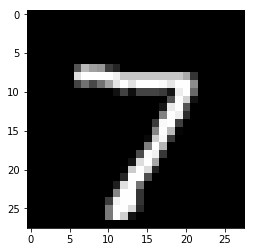

Reconstruction:


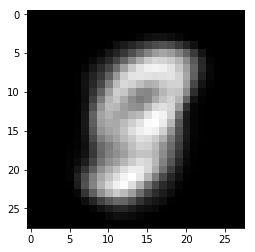

Image  1 :


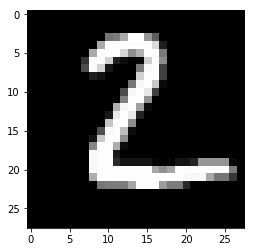

Reconstruction:


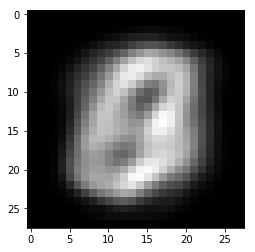

Image  2 :


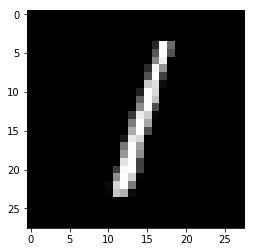

Reconstruction:


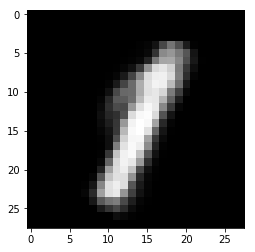

Image  3 :


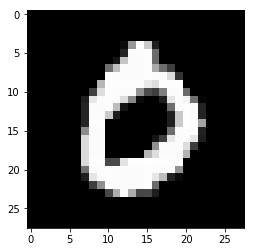

Reconstruction:


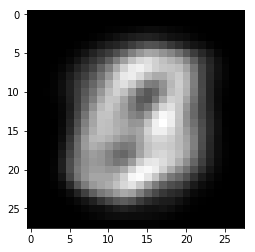

Image  4 :


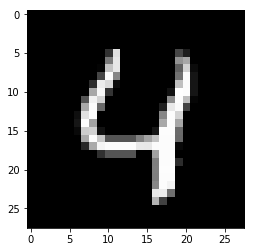

Reconstruction:


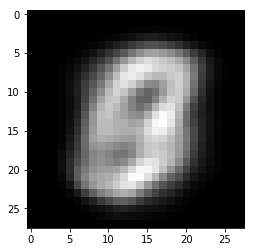

Image  5 :


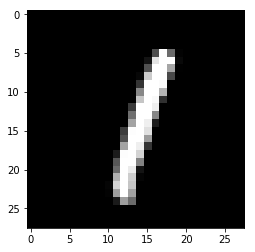

Reconstruction:


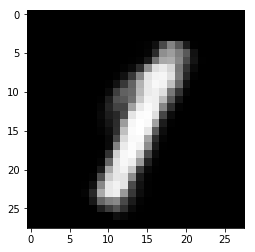

Image  6 :


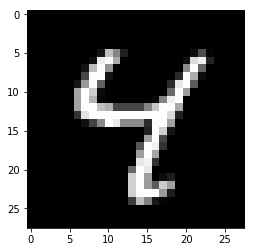

Reconstruction:


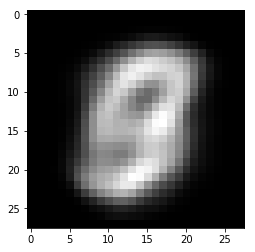

Image  7 :


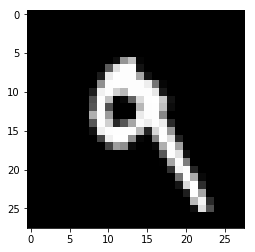

Reconstruction:


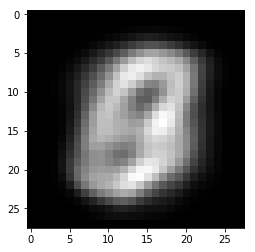

Image  8 :


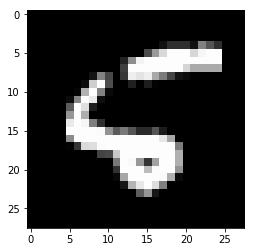

Reconstruction:


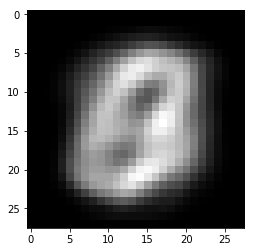

Image  9 :


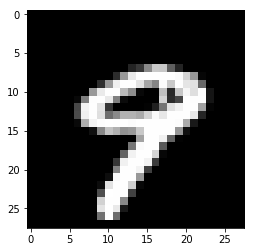

Reconstruction:


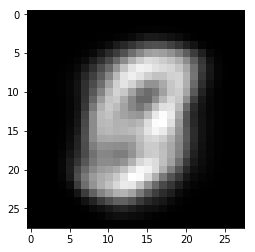

In [6]:

n_images = 10

reconstruction = sess.run(v1, feed_dict={X: teX[0:n_images], rbm_w: o_w, rbm_vb: o_vb, rbm_hb: o_hb})

for i in range(n_images):
     
  print("Image ",i, ":")
  plt.imshow(np.reshape(teX[i], [28, 28]), cmap='gray')
  plt.show()
  print("Reconstruction:")
  plt.imshow(np.reshape(reconstruction[i], [28, 28]), cmap='gray')
  plt.show()



## DBN 
Az RBM betanítása után egy kimeneti réteg deifiniálásával létrehozhatunk egy sima neuronhálót, amit tovább tudunk tanítani osztályozási feladat elvégzésére:

In [7]:
#weigths and biases for new output layer
out_w = tf.Variable(tf.random_normal([500, 10]))
out_b = tf.Variable(tf.random_normal([10]))
learning_rate = 0.01
#network definition
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.nn.sigmoid(tf.matmul(x, o_w) + o_hb)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_1, out_w) + out_b
    return out_layer

# Construct model
logits = neural_net(X)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init2 = tf.global_variables_initializer()
# Run the initializer           
sess.run(init2)


for start, end in zip(range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
  batch_x = trX[start:end]
  batch_y = trY[start:end]
  sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
  if start % 10000 == 0:
    loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
    print("Step " + str(start/batchsize) + ", Minibatch Loss= " + \
      "{:.4f}".format(loss) + ", Training Accuracy= " + \
      "{:.3f}".format(acc))

Step 0.0, Minibatch Loss= 2.7421, Training Accuracy= 0.160
Step 100.0, Minibatch Loss= 2.0712, Training Accuracy= 0.340
Step 200.0, Minibatch Loss= 2.0897, Training Accuracy= 0.250
Step 300.0, Minibatch Loss= 2.0206, Training Accuracy= 0.210
Step 400.0, Minibatch Loss= 1.9383, Training Accuracy= 0.300
Step 500.0, Minibatch Loss= 1.9462, Training Accuracy= 0.260


## Feladatok
1. Tanítsuk az RBM-et és a neuronhálót több epochon keresztül (mutassuk meg az adatot többször)!
2. Teszteljük a hálót!
3. Tanítsunk egy újabb RBM-et a korábbi kimenetén (tegyü 2 rejtett rétegesséa hálót)!
